# Step 1: Importing Required Libraries and Connections

In [1]:
pip install torchvision

In [2]:
import pandas as pnd
import numpy as nmp
import cv2, os
from google.colab.patches import cv2_imshow
import warnings
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as pt
import random
from datetime import datetime as dt
import pickle
import torch
import torchvision
from PIL import Image
import seaborn as sens
import requests
import tensorflow as tsfl
from tensorflow.keras.models import Sequential as Seq
from tensorflow.keras.layers import Conv2D, Flatten, Dense,MaxPooling2D as MPool2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split as tts

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2: Load Data and Define Labels

In [4]:
DATA_PATH = '/content/drive/MyDrive/DDNL_dataset-20231204T181353Z-001/DDNL_dataset/hmnist_28_28_RGB.csv'
csv_df = pnd.read_csv(DATA_PATH)

In [5]:
METADATA_PATH = '/content/drive/MyDrive/DDNL_dataset-20231204T181353Z-001/DDNL_dataset/HAM10000_metadata.csv'
IMAGE_SRC_DIR = '/content/drive/MyDrive/DDNL_dataset-20231204T181353Z-001/DDNL_dataset/HAM10000'

The dataset utilized is HAM10000, an acronym for "Human Against Machine with 10000".The dataset consists of 10,015 dermatoscopic pictures that have been provided for academic machine learning applications. The ISIC repository provides access to these photos. This dataset functions as a standard for evaluating machine learning algorithms and enables direct comparisons with human experts.

There are seven discrete categorizations of skin cancer, which are as follows:

1. Melanocytic nevi
2. Melanoma
3. Benign keratosis
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma


In [6]:
# Display the first 5 and last 5 rows
display(csv_df.head())
print(".\n.\n.")
display(csv_df.tail())

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


.
.
.


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,...,159,79,82,174,137,125,175,139,126,6


# Step 3: Train-Test Split

In [7]:
# Prepare data for model training
X = csv_df.drop(['label'], axis=1)  # Features
y = csv_df[['label']]  # Target variable

# Split data into training and test sets
trainx, X_test, trainy, y_test = tts(X, y, test_size=0.2, random_state=42)

# Flatten the data for model input
X_flattened = X.values.reshape(X.shape[0], -1)

# Split flattened data into training and test sets
trainx_flattened, X_test_flattened, trainy_flattened, y_test_flattened = tts(X_flattened, y, test_size=0.2, random_state=42)

In [8]:
# Preparing data for training the model
# Outputting the sizes of training and testing datasets
print(f"Length of Training Set: {len(trainx)}")
print(f"Length of Testing Set: {len(X_test)}")

# Retrieving and displaying unique labels present in the dataset
distinct_labels = csv_df['label'].unique()
print(f"Distinct Labels in Dataset: {distinct_labels}")

Length of Training Set: 8012
Length of Testing Set: 2003
Distinct Labels in Dataset: [2 4 3 6 5 1 0]


In [9]:
# Define classes and their descriptions for clarity
CLASS_NAMES = {
    0: ('akiec', 'Actinic keratoses'),
    1: ('bcc', 'Basal cell carcinoma'),
    2: ('bkl', 'Benign keratosis'),
    3: ('df', 'Dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'Vascular lesions'),
    6: ('mel', 'Melanoma'),
}

In [10]:
# Determine the computation device based on GPU availability
computation_device = torch.device("GPU" if torch.cuda.is_available() else "cpu")
print(f"Computation Device Selected: {computation_device}")


Computation Device Selected: cpu


In this project, we aim to identify seven distinct categories of skin cancer using a Convolutional Neural Network (CNN) implemented with the Keras TensorFlow framework as the backend. Subsequently, I will analyze the outcomes to assess the practical utility of the model.
We will proceed systematically to categorize the seven types of cancer.

We have executed the subsequent procedures for constructing and assessing the model, as follows:

# Step 4: Exploratory Data Analysis (EDA) and Preprocessing

In [12]:
# Load dataset metadata
table_data = pnd.read_csv('/content/drive/MyDrive/DDNL_dataset-20231204T181353Z-001/DDNL_dataset/HAM10000_metadata.csv')
# Display the first few records
table_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


<Axes: xlabel='label', ylabel='count'>

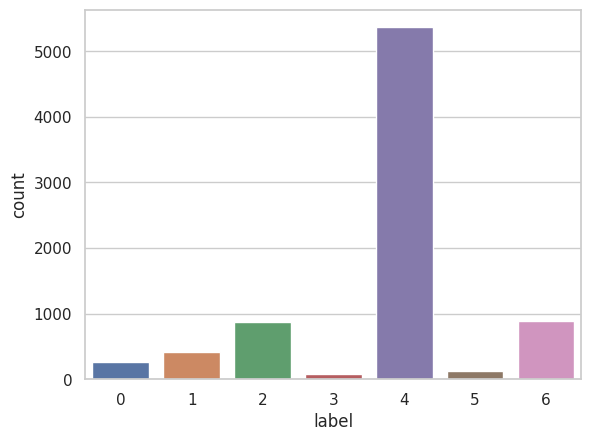

In [13]:
# Setting the visual style to 'whitegrid' for a change
sens.set(style='whitegrid')

# Using a count plot with a horizontal orientation
sens.countplot(x='label', data=trainy, orient='h')

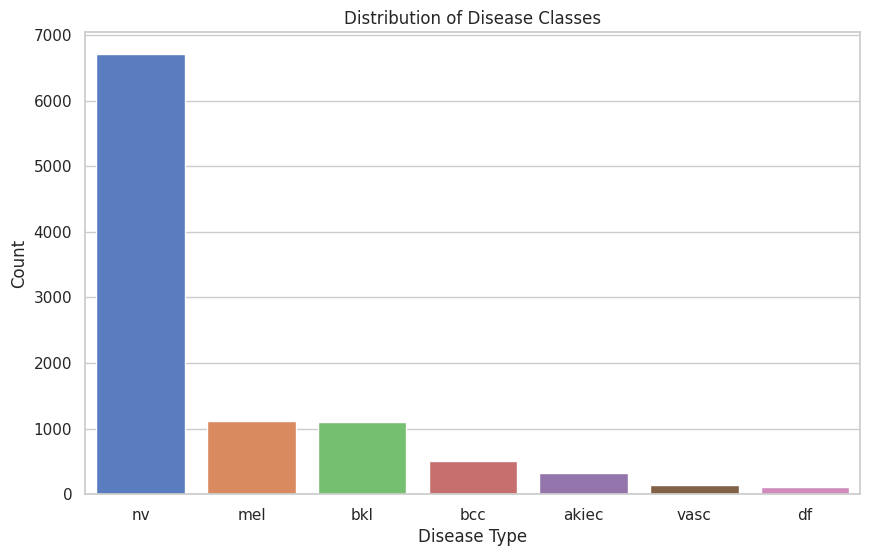

In [14]:
# 'table_data' is the DataFrame and 'dx' represents the disease classes
disease_class_counts = table_data['dx'].value_counts()

# Setting up a stacked bar chart
pt.figure(figsize=(10, 6))
sens.barplot(x=disease_class_counts.index, y=disease_class_counts, palette='muted')

# Configuring chart labels and title
pt.xlabel('Disease Type')
pt.ylabel('Count')
pt.title('Distribution of Disease Classes')

# Rendering the chart
pt.show()


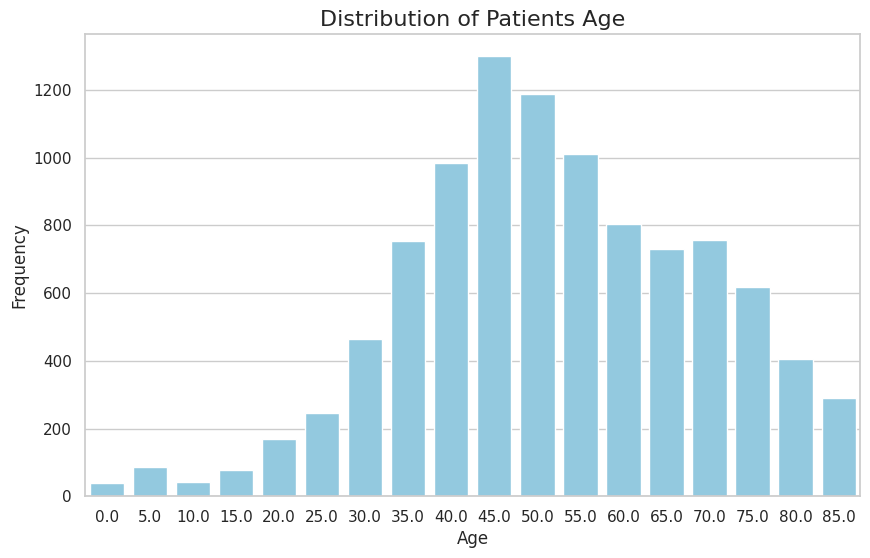

In [15]:
bar, ax = pt.subplots(figsize=(10, 6))
sens.countplot(x='age', data=table_data, ax=ax, color='skyblue')

# Adding labels and title for better interpretation
pt.xlabel('Age', size=12)
pt.ylabel('Frequency', size=12)
pt.title('Distribution of Patients Age', size=16)

# Show the plot
pt.show()

<Figure size 600x1000 with 0 Axes>

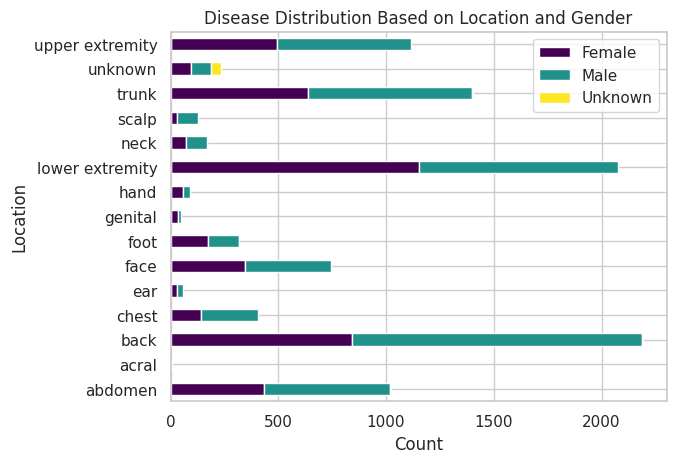

In [16]:
# Stacked bar plot for disease distribution based on location and gender
value = table_data[['localization', 'sex']].value_counts().unstack().fillna(0)
pt.figure(figsize=(6, 10))
value.plot(kind='barh', stacked=True, colormap='viridis')
pt.title('Disease Distribution Based on Location and Gender')
pt.ylabel('Location')
pt.xlabel('Count')
pt.legend(['Female', 'Male', 'Unknown'])
pt.show()

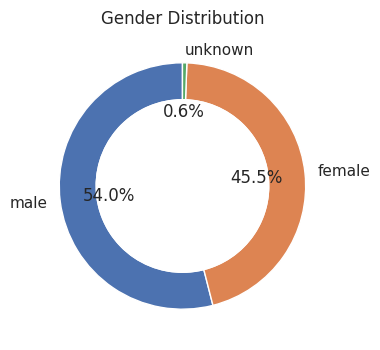

In [17]:
# Assuming 'table_data' is your DataFrame and 'sex' is the column representing gender
gender_counts = table_data['sex'].value_counts()

# Create a donut chart
fig, ax = pt.subplots(figsize=(4, 4))
ax.pie(gender_counts, labels=gender_counts.index, autopct="%.1f%%", startangle=90, wedgeprops=dict(width=0.3))

# Draw a white circle in the center to create the donut effect
centre_circle = pt.Circle((0, 0), 0.70, fc='white')
fig = pt.gcf()
fig.gca().add_artist(centre_circle)

# Adding a title
pt.title('Gender Distribution')

# Display the chart
pt.show()


In [18]:
# Initialize Random Over-Sampler for balancing the dataset
data_balancer = RandomOverSampler()
x_train, trainy = data_balancer.fit_resample(trainx, trainy)
print('Shape of X :',x_train.shape)

Shape of X : (37569, 2352)


<Axes: xlabel='count', ylabel='label'>

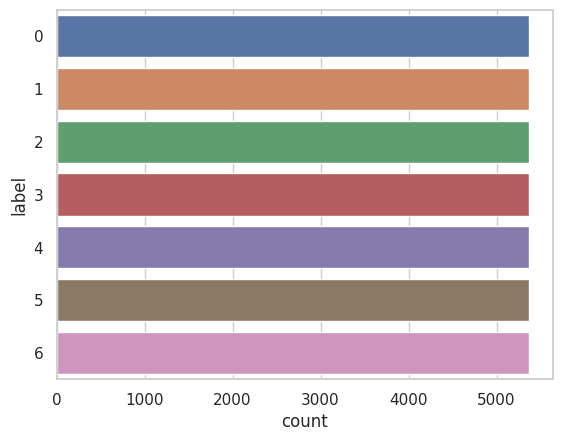

In [19]:
sens.countplot(data=trainy, y='label')

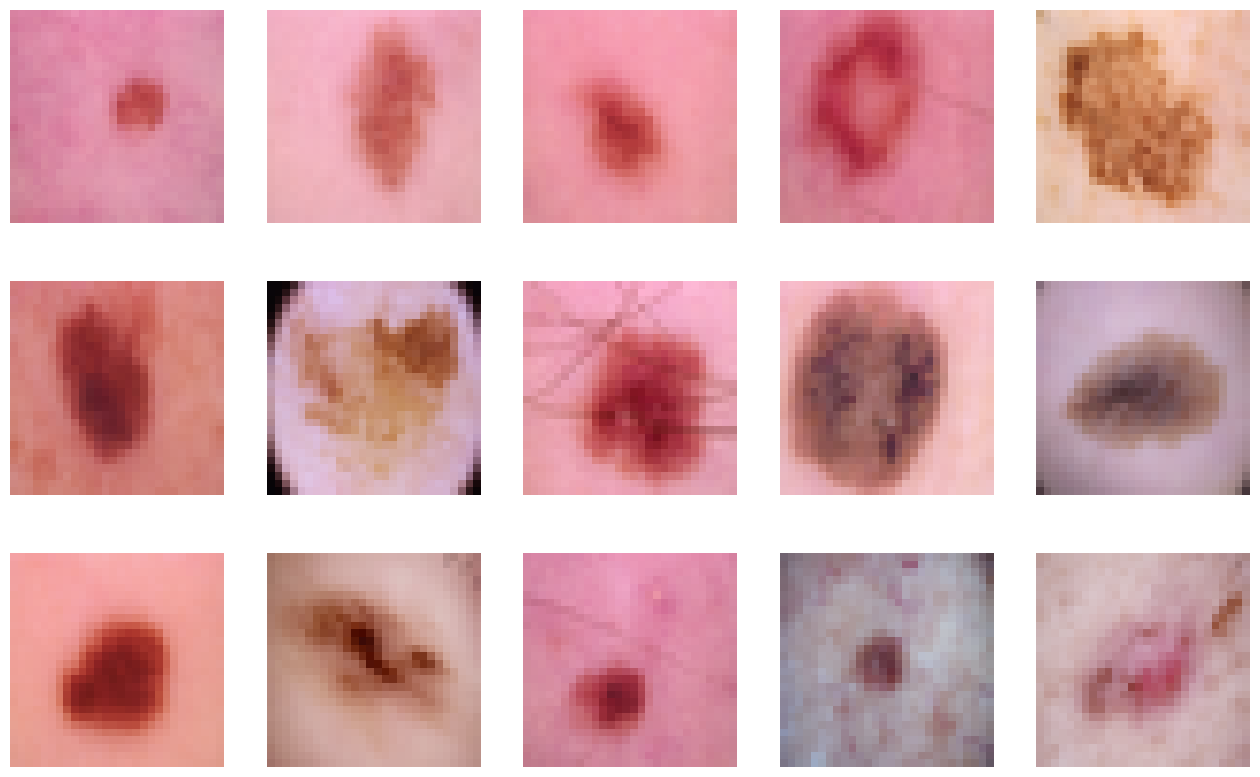

In [20]:
def display_random_images(image_set, rows=3, cols=5, figsize=(16, 10)):
    """Displays a grid of random images from the given image set."""
    fig, axes = pt.subplots(rows, cols, figsize=figsize)
    total_images = len(image_set)

    for row in range(rows):
        for col in range(cols):
            random_index = random.randint(0, total_images - 1)
            image = image_set[random_index].reshape(28, 28, 3)
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
    pt.show()

# Reshape and normalize training images
trainx = nmp.array(trainx, dtype=nmp.uint8).reshape(-1, 28, 28, 3)

# Plot random images from the training set
display_random_images(trainx)

In [22]:
trainx = (trainx-nmp.mean(trainx))/nmp.std(trainx)

In [23]:
X_test = nmp.array(X_test, dtype=nmp.uint8).reshape(-1, 28, 28, 3)
# Reshape and normalize test images
print('Shape of X :',X_test.shape)

Shape of X : (2003, 28, 28, 3)


# Step 5: Building a Model (CNN)

# Simple CNN Model

In [24]:
# Define a CNN model structure
cnn_model = Seq([
    Conv2D(16, kernel_size=(5,5), input_shape=(28, 28, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    MPool2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MPool2D(pool_size=(2,2), padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                   

# VGG Model

In [25]:
# Define a VGG-like model structure

vgg_model = Seq([
    # Block 1
    Conv2D(64, (5,5), activation='relu', padding='same', input_shape=(28, 28, 3)),
    Conv2D(64, (5,5), activation='relu', padding='same'),
    MPool2D((2, 2), strides=(2, 2)),

    # Block 2
    Conv2D(128, (5,5), activation='relu', padding='same'),
    Conv2D(128, (5,5), activation='relu', padding='same'),
    MPool2D((2, 2), strides=(2, 2)),

    # Block 3
    Conv2D(256, (5,5), activation='relu', padding='same'),
    MPool2D((2, 2), strides=(2, 2)),

    # Block 4 - Modified for smaller input size
    Conv2D(512, (5,5), activation='relu', padding='same'),
    MPool2D((2, 2), strides=(2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        4864      
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                 

# Step 6: Setting Optimizer & Callbacks



In [26]:
# Define a callback for saving the best model during training
callback = tsfl.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc',
                                              mode='max',
                                              verbose=1,
                                              save_best_only=True)

# Define the optimizer with a specified learning rate
optimizer = tsfl.keras.optimizers.Adam(lr=0.001)

# Compile the model with the optimizer, loss function, and metrics
cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
vgg_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,  # Reuse the same optimizer
                  metrics=['accuracy'])

# Step 7: Model Training


In [29]:
# Record the start time for training
start_time = dt.now()

# Train the model on the training data
cnn_hist = cnn_model.fit(trainx,
                    trainy,
                    validation_split=0.2,
                    batch_size=256,
                    epochs=50,
                    callbacks=[callback])

# Record the end time for training
end_time = dt.now()
print('Training Duration:', end_time - start_time)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.6703

26/26 [==============================] - 27s 1s/step - loss: 0.9215 - accuracy: 0.6703 - val_loss: 0.8964 - val_accuracy: 0.6787
Epoch 2/50
25/26 [===========================>..] - ETA: 1s - loss: 0.8878 - accuracy: 0.6808

26/26 [==============================] - 30s 1s/step - loss: 0.8886 - accuracy: 0.6804 - val_loss: 0.8763 - val_accuracy: 0.6968
Epoch 3/50
25/26 [===========================>..] - ETA: 1s - loss: 0.8503 - accuracy: 0.6967

26/26 [==============================] - 32s 1s/step - loss: 0.8499 - accuracy: 0.6968 - val_loss: 0.8243 - val_accuracy: 0.6974
Epoch 4/50
25/26 [===========================>..] - ETA: 0s - loss: 0.8190 - accuracy: 0.7081

26/26 [==============================] - 25s 976ms/step - loss: 0.8187 - accuracy: 0.7082 - val_loss: 0.8338 - val_accuracy: 0.6987
Epoch 5/50
25/26 [===========================>..] - ETA: 1s - loss: 0.8230 - accuracy: 0.7042

26/26 [==============================] - 32s 1s/step - loss: 0.8226 - accuracy: 0.7043 - val_loss: 0.8096 - val_accuracy: 0.7149
Epoch 6/50
25/26 [===========================>..] - ETA: 1s - loss: 0.7837 - accuracy: 0.7123

26/26 [==============================] - 27s 1s/step - loss: 0.7835 - accuracy: 0.7123 - val_loss: 0.8232 - val_accuracy: 0.6893
Epoch 7/50
25/26 [===========================>..] - ETA: 1s - loss: 0.7646 - accuracy: 0.7203

26/26 [==============================] - 29s 1s/step - loss: 0.7649 - accuracy: 0.7204 - val_loss: 0.7864 - val_accuracy: 0.7218
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.7230

26/26 [==============================] - 26s 1s/step - loss: 0.7564 - accuracy: 0.7230 - val_loss: 0.8201 - val_accuracy: 0.6831
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.7223

26/26 [==============================] - 31s 1s/step - loss: 0.7571 - accuracy: 0.7223 - val_loss: 0.8865 - val_accuracy: 0.7056
Epoch 10/50
25/26 [===========================>..] - ETA: 0s - loss: 0.7361 - accuracy: 0.7314

26/26 [==============================] - 26s 991ms/step - loss: 0.7358 - accuracy: 0.7313 - val_loss: 0.7800 - val_accuracy: 0.7149
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7401

26/26 [==============================] - 29s 1s/step - loss: 0.7054 - accuracy: 0.7401 - val_loss: 0.8375 - val_accuracy: 0.7187
Epoch 12/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6788 - accuracy: 0.7527

26/26 [==============================] - 26s 995ms/step - loss: 0.6787 - accuracy: 0.7528 - val_loss: 0.7977 - val_accuracy: 0.7006
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.7500

26/26 [==============================] - 29s 1s/step - loss: 0.6762 - accuracy: 0.7500 - val_loss: 0.7708 - val_accuracy: 0.7336
Epoch 14/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.7519

26/26 [==============================] - 26s 993ms/step - loss: 0.6628 - accuracy: 0.7516 - val_loss: 0.7387 - val_accuracy: 0.7449
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7591

26/26 [==============================] - 29s 1s/step - loss: 0.6660 - accuracy: 0.7591 - val_loss: 0.7287 - val_accuracy: 0.7374
Epoch 16/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6177 - accuracy: 0.7755

26/26 [==============================] - 26s 1s/step - loss: 0.6173 - accuracy: 0.7755 - val_loss: 0.7168 - val_accuracy: 0.7542
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.7837

26/26 [==============================] - 30s 1s/step - loss: 0.5908 - accuracy: 0.7837 - val_loss: 0.7318 - val_accuracy: 0.7187
Epoch 18/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5821 - accuracy: 0.7867

26/26 [==============================] - 26s 1s/step - loss: 0.5826 - accuracy: 0.7864 - val_loss: 0.9504 - val_accuracy: 0.6463
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.7724

26/26 [==============================] - 29s 1s/step - loss: 0.6328 - accuracy: 0.7724 - val_loss: 0.7450 - val_accuracy: 0.7498
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.8012

26/26 [==============================] - 30s 1s/step - loss: 0.5305 - accuracy: 0.8012 - val_loss: 0.7110 - val_accuracy: 0.7617
Epoch 21/50
25/26 [===========================>..] - ETA: 1s - loss: 0.5296 - accuracy: 0.8089

26/26 [==============================] - 28s 1s/step - loss: 0.5300 - accuracy: 0.8090 - val_loss: 0.9479 - val_accuracy: 0.6450
Epoch 22/50
25/26 [===========================>..] - ETA: 0s - loss: 0.5456 - accuracy: 0.7983

26/26 [==============================] - 26s 1s/step - loss: 0.5460 - accuracy: 0.7983 - val_loss: 0.7418 - val_accuracy: 0.7442
Epoch 23/50
25/26 [===========================>..] - ETA: 1s - loss: 0.4998 - accuracy: 0.8172

26/26 [==============================] - 28s 1s/step - loss: 0.5001 - accuracy: 0.8171 - val_loss: 0.7204 - val_accuracy: 0.7536
Epoch 24/50
25/26 [===========================>..] - ETA: 0s - loss: 0.4460 - accuracy: 0.8395

26/26 [==============================] - 25s 970ms/step - loss: 0.4471 - accuracy: 0.8394 - val_loss: 0.7371 - val_accuracy: 0.7386
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8315

26/26 [==============================] - 30s 1s/step - loss: 0.4637 - accuracy: 0.8315 - val_loss: 0.7290 - val_accuracy: 0.7380
Epoch 26/50
25/26 [===========================>..] - ETA: 0s - loss: 0.4001 - accuracy: 0.8547

26/26 [==============================] - 26s 1s/step - loss: 0.3998 - accuracy: 0.8547 - val_loss: 0.7643 - val_accuracy: 0.7511
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.3708 - accuracy: 0.8680

26/26 [==============================] - 29s 1s/step - loss: 0.3708 - accuracy: 0.8680 - val_loss: 0.8772 - val_accuracy: 0.7436
Epoch 28/50
25/26 [===========================>..] - ETA: 0s - loss: 0.3357 - accuracy: 0.8761

26/26 [==============================] - 26s 996ms/step - loss: 0.3360 - accuracy: 0.8761 - val_loss: 0.9226 - val_accuracy: 0.7392
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8538

26/26 [==============================] - 31s 1s/step - loss: 0.3949 - accuracy: 0.8538 - val_loss: 0.7805 - val_accuracy: 0.7523
Epoch 30/50
25/26 [===========================>..] - ETA: 1s - loss: 0.2824 - accuracy: 0.8973

26/26 [==============================] - 29s 1s/step - loss: 0.2821 - accuracy: 0.8975 - val_loss: 0.8925 - val_accuracy: 0.7461
Epoch 31/50
25/26 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.9083

26/26 [==============================] - 29s 1s/step - loss: 0.2579 - accuracy: 0.9079 - val_loss: 0.8698 - val_accuracy: 0.7230
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8822

26/26 [==============================] - 27s 1s/step - loss: 0.3200 - accuracy: 0.8822 - val_loss: 0.8481 - val_accuracy: 0.7523
Epoch 33/50
25/26 [===========================>..] - ETA: 1s - loss: 0.2111 - accuracy: 0.9267

26/26 [==============================] - 28s 1s/step - loss: 0.2109 - accuracy: 0.9268 - val_loss: 0.9496 - val_accuracy: 0.7367
Epoch 34/50
25/26 [===========================>..] - ETA: 0s - loss: 0.1644 - accuracy: 0.9431

26/26 [==============================] - 27s 1s/step - loss: 0.1645 - accuracy: 0.9430 - val_loss: 1.1466 - val_accuracy: 0.6862
Epoch 35/50
25/26 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8984

26/26 [==============================] - 28s 1s/step - loss: 0.2681 - accuracy: 0.8986 - val_loss: 0.9555 - val_accuracy: 0.7205
Epoch 36/50
25/26 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9270

26/26 [==============================] - 31s 1s/step - loss: 0.2111 - accuracy: 0.9267 - val_loss: 1.1682 - val_accuracy: 0.7342
Epoch 37/50
25/26 [===========================>..] - ETA: 1s - loss: 0.3762 - accuracy: 0.8734

26/26 [==============================] - 28s 1s/step - loss: 0.3760 - accuracy: 0.8735 - val_loss: 0.9683 - val_accuracy: 0.7218
Epoch 38/50
25/26 [===========================>..] - ETA: 0s - loss: 0.2253 - accuracy: 0.9214

26/26 [==============================] - 26s 1s/step - loss: 0.2252 - accuracy: 0.9214 - val_loss: 1.1052 - val_accuracy: 0.7355
Epoch 39/50
25/26 [===========================>..] - ETA: 1s - loss: 0.1913 - accuracy: 0.9306

26/26 [==============================] - 28s 1s/step - loss: 0.1912 - accuracy: 0.9307 - val_loss: 1.1606 - val_accuracy: 0.7037
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9597

26/26 [==============================] - 26s 997ms/step - loss: 0.1214 - accuracy: 0.9597 - val_loss: 1.2467 - val_accuracy: 0.7299
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9707

26/26 [==============================] - 29s 1s/step - loss: 0.0893 - accuracy: 0.9707 - val_loss: 1.3595 - val_accuracy: 0.7355
Epoch 42/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9822

26/26 [==============================] - 26s 1s/step - loss: 0.0581 - accuracy: 0.9822 - val_loss: 1.5070 - val_accuracy: 0.7230
Epoch 43/50
25/26 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9852

26/26 [==============================] - 29s 1s/step - loss: 0.0510 - accuracy: 0.9852 - val_loss: 1.5871 - val_accuracy: 0.7224
Epoch 44/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9847

26/26 [==============================] - 27s 1s/step - loss: 0.0503 - accuracy: 0.9847 - val_loss: 1.4829 - val_accuracy: 0.7286
Epoch 45/50
25/26 [===========================>..] - ETA: 1s - loss: 0.0253 - accuracy: 0.9959

26/26 [==============================] - 28s 1s/step - loss: 0.0253 - accuracy: 0.9959 - val_loss: 1.5794 - val_accuracy: 0.7324
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9966

26/26 [==============================] - 28s 1s/step - loss: 0.0205 - accuracy: 0.9966 - val_loss: 1.7971 - val_accuracy: 0.7417
Epoch 47/50
25/26 [===========================>..] - ETA: 1s - loss: 0.0139 - accuracy: 0.9986

26/26 [==============================] - 28s 1s/step - loss: 0.0141 - accuracy: 0.9984 - val_loss: 2.3728 - val_accuracy: 0.7143
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8966

26/26 [==============================] - 27s 1s/step - loss: 0.3156 - accuracy: 0.8966 - val_loss: 1.2142 - val_accuracy: 0.7392
Epoch 49/50
25/26 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9475

26/26 [==============================] - 28s 1s/step - loss: 0.1535 - accuracy: 0.9476 - val_loss: 1.2499 - val_accuracy: 0.7392
Epoch 50/50
25/26 [===========================>..] - ETA: 0s - loss: 0.0600 - accuracy: 0.9844

26/26 [==============================] - 27s 1s/step - loss: 0.0599 - accuracy: 0.9844 - val_loss: 1.4965 - val_accuracy: 0.7455
Training Duration: 0:23:22.113002


In [30]:
# Save training history and model
# Constructing the training history dictionary
training_history = {
    'loss': cnn_hist.history['loss'],          # Training loss
    'accuracy': cnn_hist.history['accuracy'],  # Training accuracy
    'val_loss': cnn_hist.history['val_loss'],  # Validation loss
    'val_accuracy': cnn_hist.history['val_accuracy']  # Validation accuracy
}

with open('training_history.pkl', 'wb') as file:
    pickle.dump(training_history, file)
cnn_model.save('trained_model.h5')
print("Training history and model saved successfully.")

Training history and model saved successfully.


In [31]:
with open('training_history.pkl', 'wb') as file:
    pickle.dump(training_history, file)
cnn_model.save('trained_model.h5')
print("Training history and model saved successfully.")

Training history and model saved successfully.


In [32]:
optimizer = tsfl.keras.optimizers.Adam(lr=0.001)
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

start_time = dt.now()

vgg_hist = vgg_model.fit(trainx,
                            trainy,
                            validation_split=0.2,
                            batch_size=256,
                            epochs=50,
                            shuffle=True,
                            callbacks=[callback])

# Record the end time for VGG training
end_time = dt.now()
print('VGG Training Duration:', end_time - start_time)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.3932 - accuracy: 0.6497 

26/26 [==============================] - 347s 13s/step - loss: 1.3932 - accuracy: 0.6497 - val_loss: 1.1236 - val_accuracy: 0.6719
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.6694 

26/26 [==============================] - 338s 13s/step - loss: 1.0463 - accuracy: 0.6694 - val_loss: 0.9736 - val_accuracy: 0.6719
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.9488 - accuracy: 0.6687 

26/26 [==============================] - 338s 13s/step - loss: 0.9488 - accuracy: 0.6687 - val_loss: 0.9329 - val_accuracy: 0.6719
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.6656 

26/26 [==============================] - 336s 13s/step - loss: 0.8927 - accuracy: 0.6656 - val_loss: 0.8675 - val_accuracy: 0.6725
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.8586 - accuracy: 0.6748 

26/26 [==============================] - 334s 13s/step - loss: 0.8586 - accuracy: 0.6748 - val_loss: 1.2021 - val_accuracy: 0.4492
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.9261 - accuracy: 0.6728 

26/26 [==============================] - 346s 13s/step - loss: 0.9261 - accuracy: 0.6728 - val_loss: 0.9086 - val_accuracy: 0.6712
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.8502 - accuracy: 0.6953 

26/26 [==============================] - 331s 13s/step - loss: 0.8502 - accuracy: 0.6953 - val_loss: 0.8184 - val_accuracy: 0.7062
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.7060 

26/26 [==============================] - 330s 13s/step - loss: 0.7942 - accuracy: 0.7060 - val_loss: 0.7935 - val_accuracy: 0.7056
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.7814 - accuracy: 0.7121 

26/26 [==============================] - 329s 13s/step - loss: 0.7814 - accuracy: 0.7121 - val_loss: 0.8283 - val_accuracy: 0.7012
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.7001 

26/26 [==============================] - 332s 13s/step - loss: 0.7941 - accuracy: 0.7001 - val_loss: 0.7740 - val_accuracy: 0.7118
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.7190 

26/26 [==============================] - 338s 13s/step - loss: 0.7553 - accuracy: 0.7190 - val_loss: 0.8659 - val_accuracy: 0.6925
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.7276 

26/26 [==============================] - 337s 13s/step - loss: 0.7532 - accuracy: 0.7276 - val_loss: 0.8020 - val_accuracy: 0.7049
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.7288 

26/26 [==============================] - 340s 13s/step - loss: 0.7452 - accuracy: 0.7288 - val_loss: 0.8149 - val_accuracy: 0.7105
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.7280 

26/26 [==============================] - 338s 13s/step - loss: 0.7316 - accuracy: 0.7280 - val_loss: 0.7445 - val_accuracy: 0.7293
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.7404 

26/26 [==============================] - 337s 13s/step - loss: 0.6913 - accuracy: 0.7404 - val_loss: 0.7286 - val_accuracy: 0.7311
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7557 

26/26 [==============================] - 334s 13s/step - loss: 0.6563 - accuracy: 0.7557 - val_loss: 0.7995 - val_accuracy: 0.7193
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7524 

26/26 [==============================] - 332s 13s/step - loss: 0.6607 - accuracy: 0.7524 - val_loss: 0.7438 - val_accuracy: 0.7330
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.7709 

26/26 [==============================] - 334s 13s/step - loss: 0.6124 - accuracy: 0.7709 - val_loss: 0.7772 - val_accuracy: 0.7324
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7833 

26/26 [==============================] - 334s 13s/step - loss: 0.5809 - accuracy: 0.7833 - val_loss: 0.7436 - val_accuracy: 0.7386
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.5773 - accuracy: 0.7933 

26/26 [==============================] - 332s 13s/step - loss: 0.5773 - accuracy: 0.7933 - val_loss: 0.8649 - val_accuracy: 0.6544
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7664 

26/26 [==============================] - 332s 13s/step - loss: 0.6557 - accuracy: 0.7664 - val_loss: 0.8821 - val_accuracy: 0.7162
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.8028 

26/26 [==============================] - 334s 13s/step - loss: 0.5433 - accuracy: 0.8028 - val_loss: 0.9385 - val_accuracy: 0.6288
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8089 

26/26 [==============================] - 338s 13s/step - loss: 0.5123 - accuracy: 0.8089 - val_loss: 0.8302 - val_accuracy: 0.7311
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8515 

26/26 [==============================] - 331s 13s/step - loss: 0.4195 - accuracy: 0.8515 - val_loss: 0.8441 - val_accuracy: 0.7449
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.8739 

26/26 [==============================] - 334s 13s/step - loss: 0.3489 - accuracy: 0.8739 - val_loss: 1.0929 - val_accuracy: 0.7268
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8902 

26/26 [==============================] - 331s 13s/step - loss: 0.3113 - accuracy: 0.8902 - val_loss: 1.2294 - val_accuracy: 0.7311
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.8705 

26/26 [==============================] - 331s 13s/step - loss: 0.3685 - accuracy: 0.8705 - val_loss: 0.9607 - val_accuracy: 0.7336
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9134 

26/26 [==============================] - 334s 13s/step - loss: 0.2408 - accuracy: 0.9134 - val_loss: 1.0642 - val_accuracy: 0.7037
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9387 

26/26 [==============================] - 334s 13s/step - loss: 0.1793 - accuracy: 0.9387 - val_loss: 1.2613 - val_accuracy: 0.7093
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9474 

26/26 [==============================] - 337s 13s/step - loss: 0.1525 - accuracy: 0.9474 - val_loss: 3.0223 - val_accuracy: 0.4230
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.7880 

26/26 [==============================] - 336s 13s/step - loss: 0.6497 - accuracy: 0.7880 - val_loss: 0.8954 - val_accuracy: 0.6993
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8774 

26/26 [==============================] - 338s 13s/step - loss: 0.3383 - accuracy: 0.8774 - val_loss: 1.3073 - val_accuracy: 0.6719
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9384 

26/26 [==============================] - 337s 13s/step - loss: 0.1738 - accuracy: 0.9384 - val_loss: 1.3397 - val_accuracy: 0.7336
Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9716 

26/26 [==============================] - 335s 13s/step - loss: 0.0806 - accuracy: 0.9716 - val_loss: 1.4618 - val_accuracy: 0.7293
Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9817 

26/26 [==============================] - 336s 13s/step - loss: 0.0541 - accuracy: 0.9817 - val_loss: 1.5895 - val_accuracy: 0.6931
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9860 

26/26 [==============================] - 336s 13s/step - loss: 0.0431 - accuracy: 0.9860 - val_loss: 1.9409 - val_accuracy: 0.7336
Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9587 

26/26 [==============================] - 338s 13s/step - loss: 0.1362 - accuracy: 0.9587 - val_loss: 1.3379 - val_accuracy: 0.6875
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9772 

26/26 [==============================] - 337s 13s/step - loss: 0.0717 - accuracy: 0.9772 - val_loss: 1.8110 - val_accuracy: 0.7230
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9618 

26/26 [==============================] - 333s 13s/step - loss: 0.1440 - accuracy: 0.9618 - val_loss: 1.4869 - val_accuracy: 0.7261
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9899 

26/26 [==============================] - 331s 13s/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 1.8032 - val_accuracy: 0.7249
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9970 

26/26 [==============================] - 332s 13s/step - loss: 0.0122 - accuracy: 0.9970 - val_loss: 1.9798 - val_accuracy: 0.7174
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9988 

26/26 [==============================] - 331s 13s/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 2.0542 - val_accuracy: 0.7162
Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9970 

26/26 [==============================] - 328s 13s/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 2.1500 - val_accuracy: 0.7224
Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9984 

26/26 [==============================] - 329s 13s/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 2.2193 - val_accuracy: 0.7211
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994 

26/26 [==============================] - 327s 13s/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 2.3176 - val_accuracy: 0.7243
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9997 

26/26 [==============================] - 346s 13s/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 2.2804 - val_accuracy: 0.7286
Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 7.7278e-04 - accuracy: 0.9998 

26/26 [==============================] - 349s 13s/step - loss: 7.7278e-04 - accuracy: 0.9998 - val_loss: 2.4058 - val_accuracy: 0.7268
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 3.5159e-04 - accuracy: 1.0000 

26/26 [==============================] - 341s 13s/step - loss: 3.5159e-04 - accuracy: 1.0000 - val_loss: 2.4291 - val_accuracy: 0.7293
Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 1.3987e-04 - accuracy: 1.0000 

26/26 [==============================] - 346s 13s/step - loss: 1.3987e-04 - accuracy: 1.0000 - val_loss: 2.4608 - val_accuracy: 0.7299
Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 9.7212e-05 - accuracy: 1.0000 

26/26 [==============================] - 340s 13s/step - loss: 9.7212e-05 - accuracy: 1.0000 - val_loss: 2.4843 - val_accuracy: 0.7280
VGG Training Duration: 4:40:23.977378


In [33]:
# Save training history and model for the VGG model
training_history_vgg = {
    'loss': vgg_hist.history['loss'],
    'accuracy': vgg_hist.history['accuracy'],
    'val_loss': vgg_hist.history['val_loss'],
    'val_accuracy': vgg_hist.history['val_accuracy']
}
with open('training_history_vgg.pkl', 'wb') as file:
    pickle.dump(training_history_vgg, file)
vgg_model.save('trained_model_vgg.h5')
print("VGG training history and model saved successfully.")

VGG training history and model saved successfully.


# Step 8: Model Evaluation

In [34]:
def plot_performance(model_name, training_history):
    # Setting the size of the overall figure
    pt.figure(figsize=(16, 4))

    # Plotting the Accuracy
    pt.subplot(1, 2, 1)
    pt.plot(training_history.history['accuracy'], label='Train Accuracy')
    pt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    pt.title(f'Accuracy of {model_name}')
    pt.xlabel('Epoch')
    pt.ylabel('Accuracy')
    pt.legend(loc='lower right')

    # Plotting the Loss
    pt.subplot(1, 2, 2)
    pt.plot(training_history.history['loss'], label='Train Loss')
    pt.plot(training_history.history['val_loss'], label='Validation Loss')
    pt.title(f'Loss of {model_name}')
    pt.xlabel('Epoch')
    pt.ylabel('Loss')
    pt.legend(loc='upper right')

    # Display the plots
    pt.show()


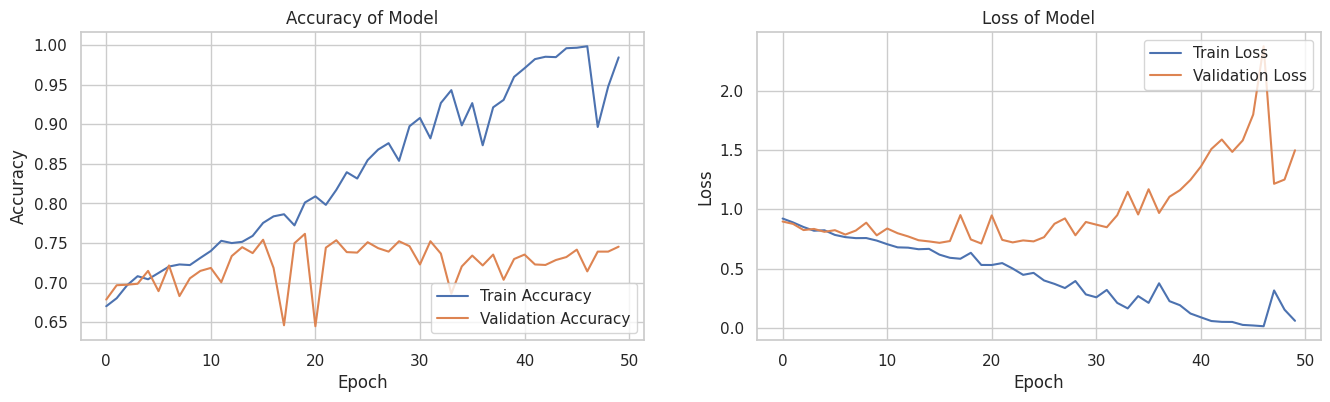

In [35]:
plot_performance('Model', cnn_hist)

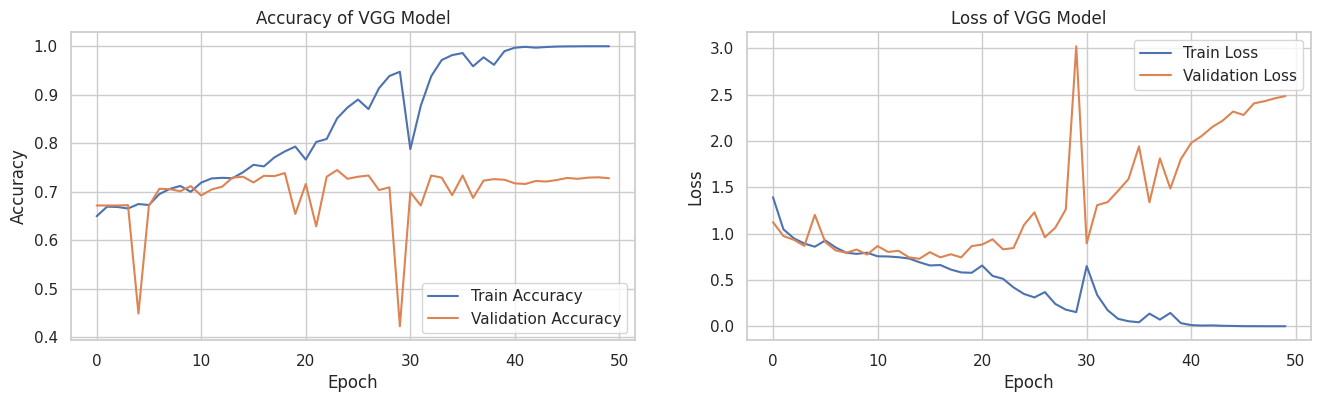

In [36]:
# Plot performance of the VGG model
plot_performance('VGG Model', vgg_hist)

In [37]:
# Evaluate CNN model on the test set
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"CNN Model Test Accuracy: {acc}")

63/63 - 3s - loss: 228.3879 - accuracy: 0.5896 - 3s/epoch - 48ms/step
CNN Model Test Accuracy: 0.5896155834197998


In [38]:
# Evaluate the VGG model on the test set
loss_vgg, acc_vgg = vgg_model.evaluate(X_test, y_test, verbose=2)
print(f"VGG Model Test Accuracy: {acc_vgg}")

63/63 - 24s - loss: 230.9247 - accuracy: 0.6410 - 24s/epoch - 377ms/step
VGG Model Test Accuracy: 0.6410384178161621


1/1 [==============================] - 0s 48ms/step


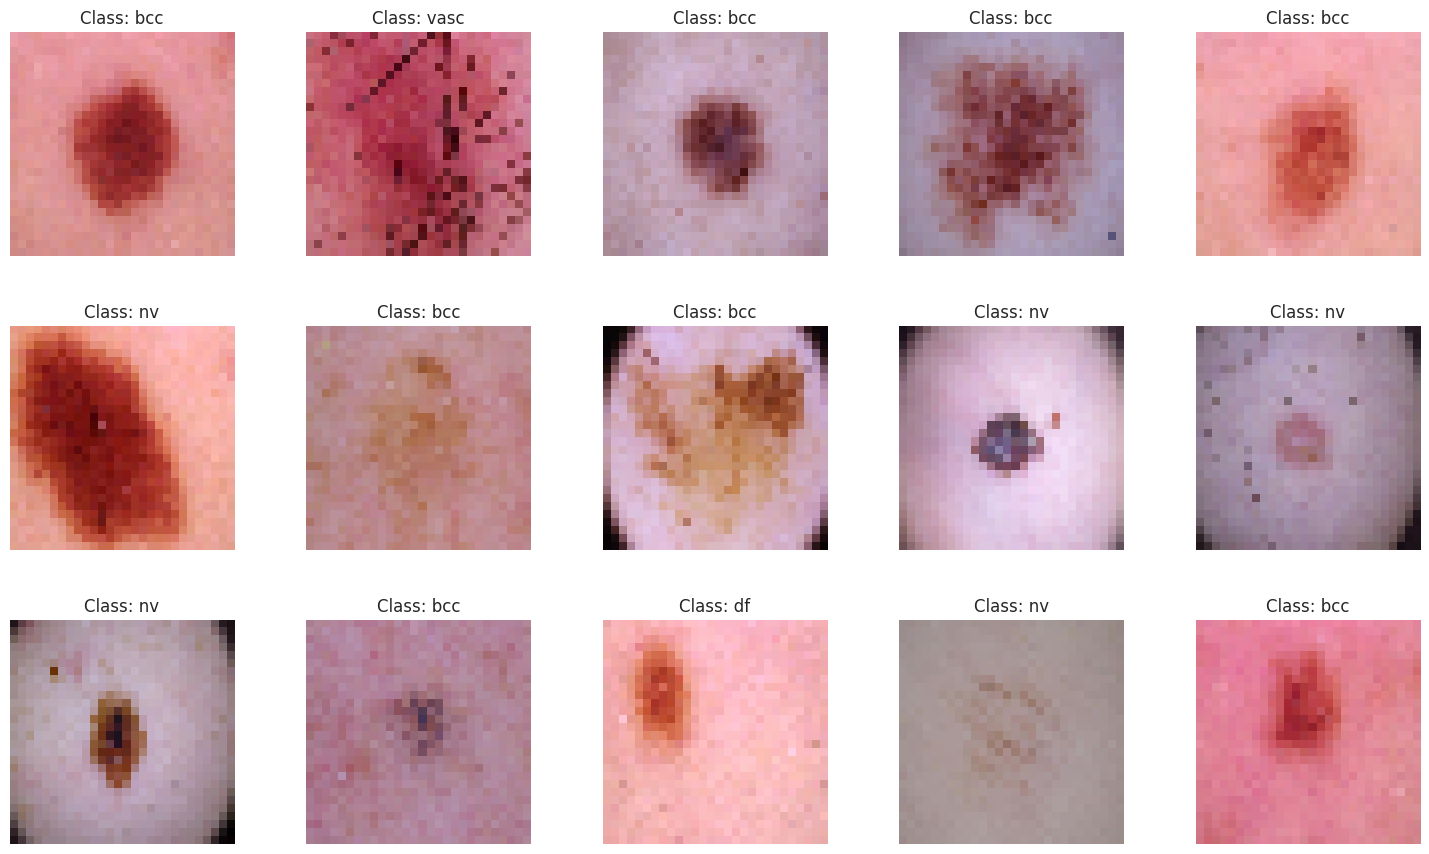

In [39]:
count = 0

# Create a 3x5 subplot
fig, axs = pt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

for i, temp in enumerate(os.listdir(IMAGE_SRC_DIR)):
    imag_path = os.path.join(IMAGE_SRC_DIR, temp)
    imag = cv2.imread(imag_path)
    imag = cv2.resize(imag, (28, 28))

    # Predict
    result = cnn_model.predict(imag.reshape(1, 28, 28, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = CLASS_NAMES[class_ind][0]

    # Display image and prediction in the subplot
    axs[i // 5, i % 5].imshow(cv2.cvtColor(imag, cv2.COLOR_BGR2RGB))
    axs[i // 5, i % 5].set_title(f'Class: {class_name}')
    axs[i // 5, i % 5].axis('off')

    count += 1
    if count >= 15:
        break

pt.show()

In [40]:
pip install nbconvert

In [44]:
!jupyter nbconvert --to=script --output=ClinicalSkinLesionDiagnosis.txt ClinicalSkinLesionDiagnosis_DLNN_Project


[NbConvertApp] Converting notebook ClinicalSkinLesionDiagnosis_DLNN_Project.ipynb to script
[NbConvertApp] Writing 14168 bytes to ClinicalSkinLesionDiagnosis.txt.py
